# Generate Bbox definition for the dataset

This notebook loads the USDA CDL dataset, and generates chip bbox across the CONUS to have a diverse distribution of classes. 
The notebook is designed for projects run at Clark University's Center for Geospatial Analytics; hence, it has certain features that are shared across multiple projects. For example, we merge all CDL classes to 13 classes before sampling. 

In [9]:
import rioxarray 
import rasterio
import numpy as np
import pandas as pd
import pyproj
import json
from shapely.geometry import Polygon

### Load CDL Data
You need to download the CDL .tiff file from USDA' website [here](https://www.nass.usda.gov/Research_and_Science/Cropland/Release/index.php) and store it under `data/`.

In [10]:
cdl_class_df = pd.read_csv("data/cdl_classes.csv", encoding = "ISO-8859-1")

In [11]:
# Drop class values that do not represent any real class (not all 256 values represent a class)
cdl_class_valid = cdl_class_df[~cdl_class_df['value'].isna()]["class"].values

In [12]:
cdl_file = "data/2022_30m_cdls.tif"

In [13]:
xds = rioxarray.open_rasterio(cdl_file, cache=False)

### Chipping

In [14]:
# Define chip specs
chip_dim_x = 224
chip_dim_y = 224
x0 = xds.x.data[0]
y0 = xds.y.data[0]
res = 30 # meters

In [15]:
# Create an empty df to load chips
df_columns = ["chip_id"]
df_columns.append(0)
for i in cdl_class_df["class"]:
    df_columns.append(i)
df_columns.append("chip_coordinate_x")
df_columns.append("chip_coordinate_y")
chips_df = pd.DataFrame(columns = df_columns)

In [17]:
# Iterate over non-overlapping chips across all of CONUS and load their properties into the df
for idx in range(0, int(np.floor(xds.shape[2] / chip_dim_x))):
    for idy in range(0, int(np.floor(xds.shape[1] / chip_dim_y))):
        chip_id = f"chip_{str(idy).zfill(3)}_{str(idx).zfill(3)}"
        chip_x0 = x0 + idx * chip_dim_x * res
        chip_y0 = y0 - idy * chip_dim_y * res
        # Note: the following line uses xarray da.sel() method which uses inclusive bounds for data selection. Hence
        # we use (chip_dim_y -1) and (chip_dim_x -1). 
        chip = xds.rio.slice_xy(chip_x0, chip_y0 - (chip_dim_y -1) * res, chip_x0 + (chip_dim_x - 1) * res, chip_y0)
        classes, class_counts = np.unique(chip.data, return_counts=True)
        # Drop chips that contain no-data value (0)
        if 0 not in classes: 
            counts = np.zeros(256)
            counts[classes] = class_counts
            chips_df.loc[len(chips_df.index)] = [chip_id] + counts.tolist() + [chip_x0, chip_y0]

### Inspect Data Distribution

<BarContainer object of 134 artists>

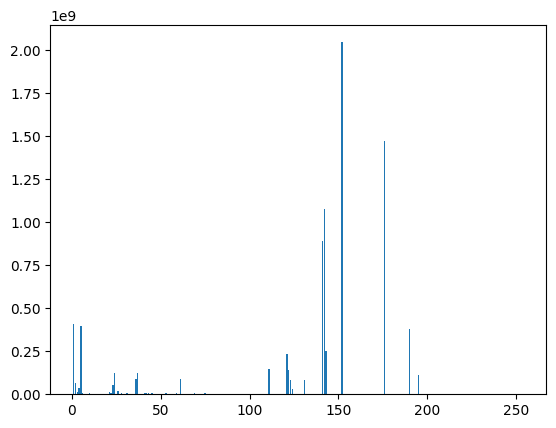

In [18]:
# Plot distribution of classes across the dataset. 
import matplotlib.pyplot as plt
plt.bar(cdl_class_valid, chips_df.loc[:, cdl_class_valid].sum())

In [19]:
# Inspecting total class distribution and define classes to merge. 
cdl_total_dst = pd.DataFrame(chips_df.loc[:, cdl_class_valid].sum(), columns=["total_count"])
cdl_total_dst["percentage"] = cdl_total_dst["total_count"] / cdl_total_dst["total_count"].sum()
cdl_total_dst.sort_values(by = "percentage", ascending = False, inplace = True)
cdl_total_dst["cum_percentage"] = cdl_total_dst["percentage"].cumsum(axis = 0)
cdl_total_dst["class_name"] = np.nan
for i in cdl_total_dst.iterrows():
    cdl_total_dst.loc[i[0], "class_name"] = cdl_class_df[cdl_class_df["class"] == i[0]]["value"].values[0]

/tmp/ipykernel_25/4007116241.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Shrubland' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  cdl_total_dst.loc[i[0], "class_name"] = cdl_class_df[cdl_class_df["class"] == i[0]]["value"].values[0]


In [20]:
# Do NOT uncomment this. This will overwrite the csv file which contains the column "new_class_value". 
# This column is added manually by inspecting the class distribution, and defines the new class values. 
# cdl_total_dst.to_csv('cdl_total_dst.csv')

Reviewed the csv manually, and defined new classes to merge. 
In the following we will load the csv again, and create a new df with new classes. 

In [21]:
cdl_total_dst = pd.read_csv("cdl_total_dst.csv")
n_classes = cdl_total_dst["new_class_value"].max()

In [22]:
chips_df_to_sample = pd.DataFrame(np.zeros((chips_df.shape[0], n_classes)), columns = np.arange(1, n_classes+1))
for row in cdl_total_dst.iterrows():
    chips_df_to_sample.loc[:, row[1]["new_class_value"]] = chips_df_to_sample.loc[:, row[1]["new_class_value"]] + chips_df.loc[:, row[1]["old_class_value"]]
chips_df_to_sample["chip_id"] =  chips_df["chip_id"]
chips_df_to_sample["chip_coordinate_x"] = chips_df["chip_coordinate_x"]
chips_df_to_sample["chip_coordinate_y"] = chips_df["chip_coordinate_y"]

In [23]:
#The following confirms that the re-classification (merging of similar classes hasn't resulted in any mistake). 
print(np.sum(chips_df_to_sample[[col for col in chips_df_to_sample.columns if col not in ["chip_coordinate_y", "chip_coordinate_x", "chip_id"]]].sum()))

print(np.sum(chips_df[[col for col in chips_df.columns if col not in ["chip_coordinate_y", "chip_coordinate_x", "chip_id"]]].sum()))

8505935872.0
8505935872.0


In [ ]:
# chips_df_to_sample.to_csv("chips_df_to_sample.csv")

### Sampling

In [24]:
def chip_weight(row):
    """
        This function return a weight for each chip (defined as a row in the df). 
        The weight is 1 - the difference between the max and min of the portion of the chip that is covered 
        by each class. e.g. if the dominant class takes 0.5 of the chip area and the least dominant one takes 0.1
        the weight would be 1 - (0.5 - 0.1). In this way, chips that have more even distribution get higher weight. 
        In addition to avoid having chips that only contain certain dominant classes, any chip with less than 8 classes
        will be punished with a weight of zero. 
    """
    weight = 1 - (np.max(row) - np.min(row)) / np.sum(row)
    if np.count_nonzero(row) < 8:
        wegiht = weight - 1
    if weight < 0:
        weight = 0
    return weight

In [25]:
chips_df_to_sample["chip_weight"] = chips_df_to_sample.loc[:, 1:n_classes].apply(chip_weight, axis = 1)

In [26]:
chips_df_to_sample["chip_weight"] = chips_df_to_sample["chip_weight"] / chips_df_to_sample["chip_weight"].sum()

In [27]:
from numpy.random import choice
samples = choice(chips_df_to_sample.index, 100000000, p = chips_df_to_sample["chip_weight"])

In [28]:
uniqe_sample, sample_count = np.unique(samples, return_counts=True)
sample_counts = np.zeros(chips_df_to_sample.index.shape)
sample_counts[uniqe_sample] = sample_count

In [29]:
chips_df_to_sample['total_samples_count'] = sample_counts

chips_df_to_sample.sort_values(by=['total_samples_count'], ascending=False, inplace=True)

In [30]:
# chips_df_to_sample.to_csv("chips_df_to_sample_sampled.csv")
chips_df_to_sample = pd.read_csv("chips_df_to_sample_sampled.csv", index_col="index")

### Generate BBoxes

<BarContainer object of 13 artists>

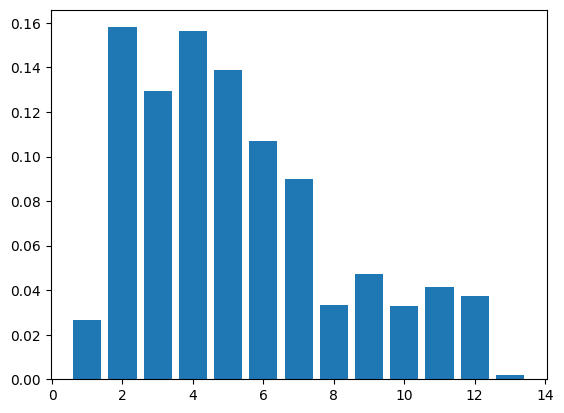

In [31]:
import matplotlib.pyplot as plt
plt.bar(range(1, n_classes+1), chips_df_to_sample.iloc[:5000, range(0, n_classes)].sum()/np.sum(chips_df_to_sample.iloc[:5000, range(0, n_classes)].sum()))

In [32]:
class_per = chips_df_to_sample.iloc[:5000, range(0, n_classes)].sum()/np.sum(chips_df_to_sample.iloc[:5000, range(0, n_classes)].sum())

In [33]:
class_weights = (1./class_per) / np.sum((1./class_per))

In [34]:
class_weights.to_csv("task_1_class_weights.csv")

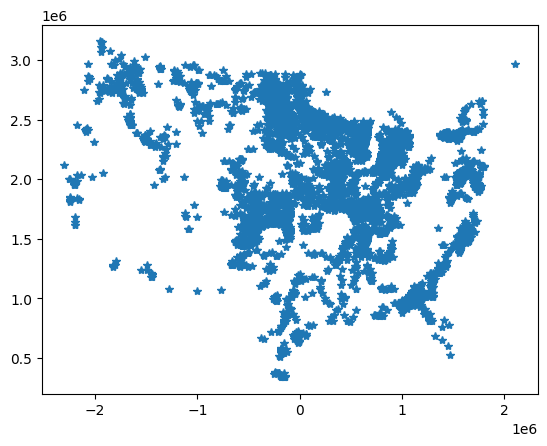

In [35]:
plt.plot(chips_df_to_sample.iloc[:5000, 17], chips_df_to_sample.iloc[:5000, 18], "*") 

In [36]:
features = []
proj = pyproj.Transformer.from_crs(5070, 4326, always_xy=True)
chip_height = chip_dim_y * res
chip_width = chip_dim_x * res
for row in chips_df_to_sample.iloc[:5000, :].iterrows():
    feature_template = [{'type': 'Feature',
                'properties': {'id': 0,
                              'center': [0, 0]},
                'geometry': {'type': 'MultiPolygon',
                'coordinates': [[[[-281415, 1533615],
                                  [256185, 1533615],
                                  [256185, 996015],
                                  [-281415, 996015],
                                  [-281415, 1533615]]]]
                            }
               }]
    # The subtraction/addition of `res` is needed in the following to change the x and y from center of the pixel to the edge
    chip_x0 = row[1]["chip_coordinate_x"] - res / 2 
    chip_y0 = row[1]["chip_coordinate_y"] + res / 2

    coor = [[[[proj.transform(chip_x0, chip_y0)[0], proj.transform(chip_x0, chip_y0)[1]],
              [proj.transform(chip_x0, chip_y0 - chip_height)[0], proj.transform(chip_x0, chip_y0 - chip_height)[1]],
              [proj.transform(chip_x0 + chip_width, chip_y0 - chip_height)[0], proj.transform(chip_x0 + chip_width, chip_y0 - chip_height)[1]],
              [proj.transform(chip_x0 + chip_width, chip_y0)[0], proj.transform(chip_x0 + chip_width, chip_y0)[1]],
              [proj.transform(chip_x0, chip_y0)[0], proj.transform(chip_x0, chip_y0)[1]]
         ]]]
    chip_cen = [chip_x0 + chip_width / 2, chip_y0 - chip_height / 2]
    chip_cen_lon, chip_cen_lat = proj.transform(chip_cen[0], chip_cen[1])
    
    feature_template[0]['geometry']['coordinates'] = coor
    feature_template[0]['properties']['id'] = row[1]["chip_id"]
    feature_template[0]['properties']['center'] = [chip_cen_lon, chip_cen_lat] 
    features.extend(feature_template)

feature_collection = {
'type': 'FeatureCollection',
 'name': 'chips',
 'crs': {'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:EPSG::4326'}},
 'features': features
}

In [37]:
with open("data/chip_bbox_task_1.geojson", 'w') as outfile:
    json.dump(feature_collection, outfile)

Generating the same geojson files but with coordinates in 5070 for chipping

In [38]:
features = []
chip_height = chip_dim_y * res
chip_width = chip_dim_x * res
for row in chips_df_to_sample.iloc[:5000, :].iterrows():
    feature_template = [{'type': 'Feature',
                'properties': {'id': 0,
                              'center': [0, 0]},
                'geometry': {'type': 'MultiPolygon',
                'coordinates': [[[[-281415, 1533615],
                                  [256185, 1533615],
                                  [256185, 996015],
                                  [-281415, 996015],
                                  [-281415, 1533615]]]]
                            }
               }]
    # The subtraction/addition of `res` is needed in the following to change the x and y from center of the pixel to the edge
    chip_x0 = row[1]["chip_coordinate_x"] - res / 2
    chip_y0 = row[1]["chip_coordinate_y"] + res / 2

    coor = [[[[chip_x0, chip_y0],
              [chip_x0, chip_y0 - chip_height],
              [chip_x0 + chip_width, chip_y0 - chip_height],
              [chip_x0 + chip_width, chip_y0],
              [chip_x0, chip_y0]
         ]]]
    chip_cen = [chip_x0 + chip_width / 2, chip_y0 - chip_height / 2]
    chip_cen_lon, chip_cen_lat = [chip_cen[0], chip_cen[1]]
    
    feature_template[0]['geometry']['coordinates'] = coor
    feature_template[0]['properties']['id'] = row[1]["chip_id"]
    feature_template[0]['properties']['center'] = [chip_cen_lon, chip_cen_lat] 
    features.extend(feature_template)

feature_collection = {
'type': 'FeatureCollection',
 'name': 'chips',
 'crs': {'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:EPSG::5070'}},
 'features': features
}

In [39]:
with open("data/chip_bbox_task_1_5070.geojson", 'w') as outfile:
    json.dump(feature_collection, outfile)